In [33]:
import tensorflow as tf
TRAIN_DIR = '../EmotionsDataset/train/'
TEST_DIR = '../EmotionsDataset/test/'
CLASS_NAMES = ['angry','happy','sad']
# Updated Configuration
CONFIGURATION = {
    'BATCH_SIZE': 32,
    'IM_SIZE': 256,
    'N_EPOCHS': 30,
    'LEARNING_RATE': 0.001,
    'NUM_CLASSES': 3,
}

In [34]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory=TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory=TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [35]:
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping
csv_logger = CSVLogger("renetLogs.csv",separator=',',append=False)
es_callback = EarlyStopping(restore_best_weights=True,patience=4)
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

sched = LearningRateScheduler(scheduler, verbose=1)

In [36]:
# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize images to 224x224
    image = tf.cast(image, tf.float32)  # Convert images to float32
    return image, label

train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Normalization function
def normalise(image, label):
    return image / 255.0, label

# Apply normalization
train_dataset = train_dataset.map(normalise)
test_dataset = test_dataset.map(normalise)

# # Apply shuffling, batching, and prefetching
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [37]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [38]:
from keras.layers import Add,Conv2D,Layer, MaxPooling2D, Dense, InputLayer, Flatten, BatchNormalization, GlobalAveragePooling2D, BatchNormalization, Activation
class CustomConv2D(Layer):
    def __init__(self, filters, kernel_size, strides=1, padding='valid'): # Add data_format
        super(CustomConv2D, self).__init__()
        self.conv2D = Conv2D(filters, kernel_size, strides, padding=padding) # Set data_format for Conv2D
        self.batchNorm = BatchNormalization()

    def call(self, x, training=True):
        # Ensure x is of shape (batch_size, height, width, channels)
        x = self.conv2D(x)
        x = self.batchNorm(x, training=training)
        return x

In [39]:
class ResidualBlock(Layer):
    def __init__(self, n_channels, n_strides=1):
        super(ResidualBlock, self).__init__(name="residual_layer")
        self.dotted = (n_strides != 1) or (n_channels != 3)  # Adjust the check for the number of channels
        self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding="same")
        self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding="same")
        self.activation = Activation("relu")
        
        if self.dotted:
            self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

    def call(self, Input, training=False):
        x = self.custom_conv_1(Input, training=training)
        x = self.custom_conv_2(x, training=training)
        
        if self.dotted:
            x_add = self.custom_conv_3(Input, training=training)
            x_add = Add()([x, x_add])
        else:
            x_add = Add()([x, Input])
        
        return self.activation(x_add)


In [40]:
from keras.models import Model
import tensorflow as tf # Import tensorflow

class ResNet34(Model):
    def __init__(self, num_classes):
        super(ResNet34, self).__init__(name="resnet_34")
        # Input layer with explicit input shape
        self.conv_1 = CustomConv2D(67,3,2, padding='same')
        self.max_pool = MaxPooling2D(3, 2)

        # Residual Layers
        self.conv_2_1 = ResidualBlock(64)
        self.conv_2_2 = ResidualBlock(64)
        self.conv_2_3 = ResidualBlock(64)
        
        self.conv_3_1 = ResidualBlock(128, 2)
        self.conv_3_2 = ResidualBlock(128)
        self.conv_3_3 = ResidualBlock(128)
        
        self.conv_4_1 = ResidualBlock(256, 2)
        self.conv_4_2 = ResidualBlock(256)
        self.conv_4_3 = ResidualBlock(256)
        
        self.conv_5_1 = ResidualBlock(512, 2)
        self.conv_5_2 = ResidualBlock(512)
        self.conv_5_3 = ResidualBlock(512)

        # Global Average Pooling and Fully Connected
        self.global_pool = GlobalAveragePooling2D()
        self.fc = Dense(num_classes, activation='softmax')

    def call(self, x, training=True):
        # Pass through the first convolutional layer
        x = self.conv_1(x, training=training)
        x = self.max_pool(x)
    
        # Now process the residual blocks
        x = self.conv_2_1(x, training=training)
        x = self.conv_2_2(x, training=training)
        x = self.conv_2_3(x, training=training)
    
        x = self.conv_3_1(x, training=training)
        x = self.conv_3_2(x, training=training)
        x = self.conv_3_3(x, training=training)
    
        x = self.conv_4_1(x, training=training)
        x = self.conv_4_2(x, training=training)
        x = self.conv_4_3(x, training=training)
    
        x = self.conv_5_1(x, training=training)
        x = self.conv_5_2(x, training=training)
        x = self.conv_5_3(x, training=training)
    
        x = self.global_pool(x)
        return self.fc(x)

In [41]:
model = ResNet34(num_classes=CONFIGURATION['NUM_CLASSES'])
# Build the model (define the input shape accordingly)
model(tf.zeros([1,224, 224, 3]),training= False)  # Example input shape with batch size 1
model.summary()

Model: "resnet_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_conv2d_167               │ ?                      │         2,144 │
│ (CustomConv2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (1, 55, 55, 67)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │        80,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │        78,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │        78,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │       231,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │       313,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │       313,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │       921,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │     1,249,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │     1,249,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │     3,677,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │     4,988,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │     4,988,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (1, 512)               │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1, 3)                 │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,173,603 (69.33 MB)

 Trainable params: 18,156,189 (69.26 MB)

 Non-trainable params: 17,414 (68.02 KB)

In [42]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
# Compile the model
model.compile(optimizer=Adam(),
              loss=CategoricalCrossentropy(),
              metrics=[CategoricalAccuracy()])

In [43]:
# When defining the input, ensure you have the correct shape
input_shape = (224, 224, 3)


# Now train your model
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=test_dataset,
                    callbacks=[csv_logger, es_callback, sched])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - categorical_accuracy: 0.4543 - loss: 1.2625

2024-09-21 17:44:52.170964: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


213/213 ━━━━━━━━━━━━━━━━━━━━ 152s 490ms/step - categorical_accuracy: 0.4545 - loss: 1.2609 - val_categorical_accuracy: 0.4416 - val_loss: 1.1382 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 69s 322ms/step - categorical_accuracy: 0.5041 - loss: 1.0222 - val_categorical_accuracy: 0.4802 - val_loss: 2.1114 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 68s 317ms/step - categorical_accuracy: 0.5114 - loss: 0.9981 - val_categorical_accuracy: 0.3859 - val_loss: 4.0510 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 67s 312ms/step - categorical_accuracy: 0.5464 - loss: 0.9571 - val_categorical_accuracy: 0.3946 - val_loss: 1.1749 - learning_rate: 9.0484e-04

Epoch 5: LearningRateScheduler setting learning r

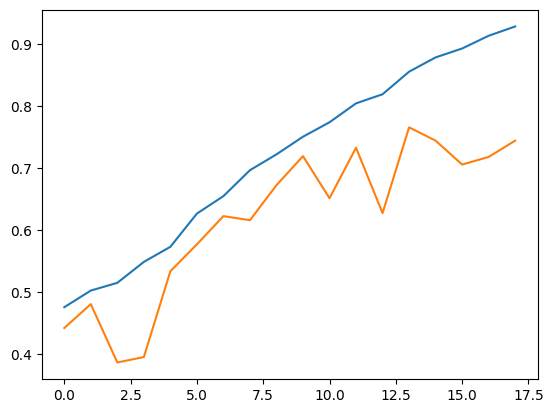

In [44]:
import matplotlib.pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

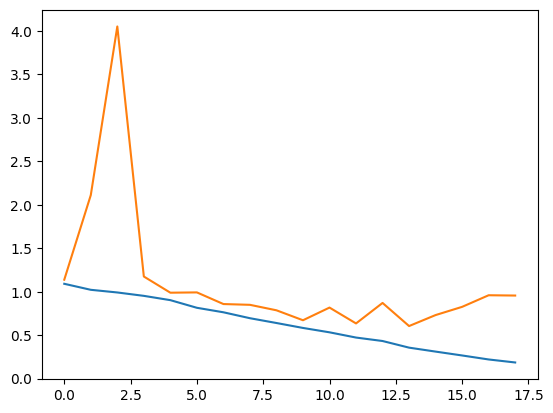

In [46]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])